<a href="https://colab.research.google.com/github/Yolantele/ML-data-clasifier/blob/master/NL_SpaCy_ML_Classifier_for_Waste_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dutch Waste Data Classification and Augmentation** 

Performs text analysis operations with spaCy and  builds machine learning model with scikit-learn


scikit-learn :
https://scikit-learn.org/stable/

spaCy Language Models:
https://spacy.io/usage/models

sickitk-learn + Spacy : 
https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

Eural Code reference: 
https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=CELEX:02000D0532-20150601


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# mount data from drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install -U spacy
!pip install pandas
!python -m spacy download nl_core_news_md

In [ ]:
import spacy
import pandas as pd
from spacy.lang.nl import Dutch
import nl_core_news_md
spacy.prefer_gpu()

nlp = nl_core_news_md.load

In [109]:
path = '/content/drive/My Drive/data/'

#data sets:
materials = pd.read_csv(path + '/nlMaterialData.csv')
materials_from_eural_descriptions = pd.read_csv(path + '/nlWithEuralDescriptions.csv')

# or use test data frame where material field is empty
materials_test = pd.read_csv(path + '/nlWithoutMaterialData.csv')

# df = materials_from_eural_descriptions
df = materials # change to materials_test for no material assigned

df.head()
# df.info()
# df.description + df.euralDescription
# df.description + df.euralDescription


,reason,origin,color,state,size,consistency,otherCode,material4,material3,material2,material,mType,composite2,composite1,cType,indirectProduct,directProduct,pType,mixedOrPure,cleanOrDirty,euralDescription,euralCode,description,/0
0,afgekeurd,NaN,NaN,NaN,NaN,vast,NaN,NaN,NaN,NaN,organisch materiaal,NaN,NaN,GFT,NaN,GFT,NaN,NaN,gemengd,NaN,afval van dierlijke weefsels,20102,GFT Afgekeurd,NaN
1,NaN,NaN,NaN,NaN,NaN,vast,categorie 3,NaN,NaN,NaN,organisch materiaal,NaN,NaN,GFT,NaN,GFT,NaN,NaN,puur,NaN,afval van dierlijke weefsels,20102,GFT Categorie 3,NaN
2,NaN,NaN,NaN,NaN,NaN,vast,200,NaN,NaN,NaN,hout,stobben,NaN,NaN,NaN,hout,NaN,NaN,puur,NaN,afval van plantaardige weefsels,20103,200 Boomstobben,NaN
3,NaN,NaN,NaN,NaN,NaN,vast,NaN,NaN,NaN,NaN,gras,bermgras,NaN,NaN,NaN,gras,NaN,NaN,puur,NaN,afval van plantaardige weefsels,20103,BERMGRAS,NaN
4,NaN,NaN,NaN,NaN,NaN,vast,NaN,NaN,NaN,NaN,organisch materiaal,blauwmaanzaad,NaN,NaN,NaN,organisch materiaal,NaN,NaN,puur,NaN,afval van plantaardige weefsels,20103,BLAUWMAANZAAD TER VERNIETIGING,NaN


## **Tokening the Data With spaCy**

creating a custom tokenizer function using spaCy to automatically strip unnecesarry information like stopwords and punctuation

In [110]:
parser = Dutch()
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

def spacy_tokenize(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    sentence = sentence.strip().lower()
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens


###**Vectorization Feature Engineering, TF-IDF, Bag of Words and N-grams**

Classifying text we end up with text snippets with their respective labels. But in machine learning model we need to convert into numeric representation (vector coordinates)

- **TF-IDF -Term Frequency-Inverse Document Frequency**- simply a way of normalizing our Bag of Words(BoW) by looking at each word’s frequency in comparison to the document frequency.

- **N-grams** - combinations of adjacent words in a given text. For example "who will win"
 1. when n = 1, becomes "who", "will", "win",
 2. when n = 2 , becomes "who will", "will win" etc. 

In [111]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin


#bag of words vector
bow_vector = CountVectorizer(tokenizer=spacy_tokenize, ngram_range=(1,1))
print(bow_vector)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenize at 0x7f7cf6f800d0>,
                vocabulary=None)


In [112]:
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenize)
print(tfidf_vector)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenize at 0x7f7cf6f800d0>,
                use_idf=True, vocabulary=None)


## **Splitting The Data into Training and Validation Sets**


In [113]:
from sklearn.model_selection import train_test_split


X = df['description'] # the features we want to analyze
ylabels = df['material'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

print(X)

0                                           GFT Afgekeurd
1                                         GFT Categorie 3
2                                         200 Boomstobben
3                                                BERMGRAS
4                          BLAUWMAANZAAD TER VERNIETIGING
                              ...                        
3695                                          fruitresten
3696                             gft vloeibare reststrome
3697            consumptie ongeschikt mat. (palmvetzuren)
3698                                              zetmeel
3699    voedings-en genotmiddelen ongeschikt voor cons...
Name: description, Length: 3700, dtype: object


## **Creating a Pipeline and Generating the Model**

###we’ll create a pipeline with three components: a **cleaner, a vectorizer, and a classifier**. 

- The cleaner uses our predictors class object to clean and preprocess the text. 

- The vectorizer uses countvector objects to create the bag of words matrix for our text. 

- The classifier is an object that performs the logistic regression to classify the sentiments.

In [114]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}


def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Creating Logistic Regression Classifier
classifier = LogisticRegression()

# Create pipeline using Bag of Words (BoW)
model = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# model generation
model.fit(X_train,y_train)

In [130]:
import pickle
# save the model to disk
filename = path + 'nl_material_classification_model.sav'
pickle.dump(model, open(filename, 'wb'))
 
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)

print('loaded model score---', result)

loaded model score--- 0.7828828828828829


## **Predictions - Model Classifications**

In [131]:
from sklearn import metrics

row = 8

# Predicting for a test dataset
predicted = model.predict(X_test)
print('Using validation set:')

print('material description was ----> ', X_test.iloc[row])
print('material predicted is ----->', predicted[row])


# predict using unclassified set
pred = model.predict(materials_test)
print('')
print('Using test set (unclassified):')
print('material description was ----> ', materials_test.iloc[row].description)
print('material predicted is ----->', pred[row])


Using validation set:
material description was ---->  Grond, Provincialeweg 5B 73, Alkmaar
material predicted is -----> grond

Using test set (unclassified):
material description was ---->  Bedding afval
material predicted is -----> organisch materiaal


## **Model Accuracy Reports**

**Accuracy** refers to the percentage of the total predictions our model makes that are completely correct.

**Precision** describes the ratio of true positives to true positives plus false positives in our predictions.

**Recall** describes the ratio of true positives to true positives plus false negatives in our predictions.


In [132]:

# Model Accuracy Reports

print("Accuracy:",metrics.accuracy_score(y_test, predicted ))
print("Precision:",metrics.precision_score(y_test, predicted, average='weighted'))
print("Recall:",metrics.recall_score(y_test, predicted, average='weighted'))
print( metrics.classification_report(y_test, predicted))

Accuracy: 0.7828828828828829
Precision: 0.8182770695414715
Recall: 0.7828828828828829
                     precision    recall  f1-score   support

                ABS       0.00      0.00      0.00         1
                EPS       1.00      0.79      0.88        14
               HDPE       0.00      0.00      0.00         1
               LDPE       1.00      1.00      1.00        13
                OPP       0.00      0.00      0.00         1
                 PC       0.00      0.00      0.00         2
                 PE       0.00      0.00      0.00         1
                PET       0.00      0.00      0.00         3
               PFOS       0.00      0.00      0.00         1
               PMMA       0.00      0.00      0.00         1
                 PP       1.00      0.83      0.91         6
                 PS       1.00      0.75      0.86         4
                PVC       1.00      0.60      0.75         5
                RVS       1.00      0.60      0.75         

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **Plotting the Classification Outcomes (description and material dependencies)**

UFuncTypeError: ignored

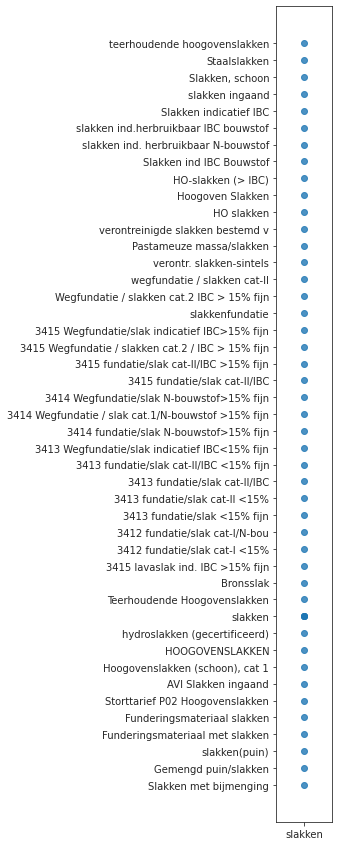

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt


chosen_material = 'slakken'

data = df.loc[df.material ==chosen_material]
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(1, 15)
sns.regplot(x='material', y='description', data=data, ax=ax)
